In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import math
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

In [177]:
# parent directory
parent_dir = Path.cwd().parent

# path to the dataset
train_data_path = os.path.join(parent_dir ,'data','raw','weekly-train-1.csv')

# reading a CSV file into a DataFrame
train_df = pd.read_csv(train_data_path)
train_df = train_df[train_df['TOTAL_SALES'] > 0]

# path to the test dataset
test_data_path = os.path.join(parent_dir ,'data','raw','weekly-test-1.csv')

# reading a CSV file into a DataFrame
test_df = pd.read_csv(test_data_path)

# concatenating the training and test datasets for data engineering purposes
train_df['split'] = 'train'
test_df['split'] = 'test'
test_df['TOTAL_SALES'] = np.nan

# concatenate for consistent feature engineering on both datasets
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [178]:
# sorting by date and product ID to ensure correct order for time series analysis
df.sort_values(["DATE", "PRODUCT_ID"], inplace=True)

In [179]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,split
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,True,False,True,False,False,False,False,False,False,False,False,False,train
127,Yogurt_Mini_Light,3450015116,2020-12-28,6858.569570,4.997333,False,False,False,False,False,False,False,False,False,False,False,False,False,train
254,Yogurt_Classic,3450015119,2020-12-28,20663.357359,4.804220,False,False,False,False,False,False,False,False,False,False,False,False,False,train
381,Yogurt_Mini_Classic,3450015129,2020-12-28,7592.988504,5.000104,False,False,False,False,False,False,False,False,False,False,False,False,False,train
508,Yogurt_Mini_Greek,3450015179,2020-12-28,7317.517962,5.714844,False,False,False,False,False,False,False,False,False,False,False,False,False,train


In [180]:
# creating df_test_original for presenting results later
df_test_original = df[df['split'] == 'test'].copy()
df_test_original.drop(columns=['TOTAL_SALES', 'split'], inplace=True)
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False
1041,Yogurt_Mini_Light,3450015116,2023-06-05,5.748021,False,False,False,False,False,False,False,False,False,False,False,False,False
1093,Yogurt_Classic,3450015119,2023-06-05,5.230849,False,False,False,False,False,False,False,False,False,False,False,False,False
1145,Yogurt_Mini_Classic,3450015129,2023-06-05,5.748474,True,False,True,True,False,False,False,False,False,False,False,False,False
1197,Yogurt_Mini_Greek,3450015179,2023-06-05,6.570619,False,False,False,False,False,False,False,False,False,False,False,False,False


In [181]:
# notice how 'tot_sales' minimum value is 0, which could be a problem for MAPE calculation
df.describe()

,PRODUCT_ID,TOTAL_SALES,PRICE
count,1.405000e+03,989.000000,1405.000000
mean,1.834992e+11,11065.805785,6.200888
std,3.244396e+11,9287.676139,1.629093
min,3.450014e+09,1628.913015,2.692734
25%,3.450015e+09,5228.798606,4.999980
50%,3.450015e+09,7633.006153,5.715059
75%,3.450015e+09,15626.911843,6.573549
max,7.677070e+11,45877.859803,10.502462


In [182]:
test_path = os.path.join(parent_dir ,'data','raw','weekly-test-1.csv')
test_df = pd.read_csv(test_path)

In [183]:
test_df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY
0,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Yogurt_Greek,3450014449,2023-06-12,6.176059,False,False,True,True,False,False,False,False,False,False,False,False,False
2,Yogurt_Greek,3450014449,2023-06-19,6.175545,False,False,True,True,False,False,False,False,False,False,False,False,False
3,Yogurt_Greek,3450014449,2023-06-26,6.178684,False,False,False,False,True,False,False,False,False,False,False,False,False
4,Yogurt_Greek,3450014449,2023-07-03,6.176310,False,False,False,False,True,False,False,False,False,False,False,False,False


In [184]:
df.shape

(1405, 19)

In [185]:
# checking for missing values in the DataFrame
df.isnull().sum()

PRODUCT_DESC              0
PRODUCT_ID                0
DATE                      0
TOTAL_SALES             416
PRICE                     0
IS_COUPON                 0
IS_DISPLAY                0
IS_FEATURE                0
IS_PROMO                  0
IS_INDEPENDENCE_DAY       0
IS_PRE_CHRISTMAS          0
IS_SUPER_BOWL_SUNDAY      0
IS_PRE_THANKSGIVING       0
IS_EASTER_SUNDAY          0
IS_LABOR_DAY              0
IS_MEMORIAL_DAY           0
IS_THANKSGIVING           0
IS_CHRISTMAS_DAY          0
split                     0
dtype: int64

In [186]:
# checking the data types of each column in the DataFrame
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

PRODUCT_DESC: str
PRODUCT_ID: int64
DATE: str
TOTAL_SALES: float64
PRICE: float64
IS_COUPON: bool
IS_DISPLAY: bool
IS_FEATURE: bool
IS_PROMO: bool
IS_INDEPENDENCE_DAY: bool
IS_PRE_CHRISTMAS: bool
IS_SUPER_BOWL_SUNDAY: bool
IS_PRE_THANKSGIVING: bool
IS_EASTER_SUNDAY: bool
IS_LABOR_DAY: bool
IS_MEMORIAL_DAY: bool
IS_THANKSGIVING: bool
IS_CHRISTMAS_DAY: bool
split: str


In [187]:
# converting the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].dtype.name)

datetime64[us]


## Feature Engineering
Re-arranging some features in order to be able to extract useful information

### Promotion Features
Boolean features: the most important one is IS_PROMO, which indicates if there was any promotion.
IS_COUPON, IS_DISPLAY, IS_FEATURE are support variables that might increase the TOT_SALES.

Promotion features can be summarized in a PROMO_LEVEL feature, that indicates how much promoted the product in the week was. This new feature can be realized in different ways: by a naive summation of the attributes or by a weighted sum.

In [188]:
#converting boolean values in dummy variables for promo features
df['IS_PROMO']=df['IS_PROMO'].astype(int)
df['IS_COUPON']=df['IS_COUPON'].astype(int)
df['IS_DISPLAY']=df['IS_DISPLAY'].astype(int)
df['IS_FEATURE']=df['IS_FEATURE'].astype(int)

In [189]:
# creating a feature that indicates promotional level
# NOTICE: this can be improved, eventually considering a weighted sum based on promo supports
df['PROMO_LEVEL'] = df['IS_PROMO'] + df['IS_COUPON'] + df['IS_DISPLAY'] + df['IS_FEATURE']
df.drop(columns=['IS_PROMO', 'IS_COUPON', 'IS_DISPLAY', 'IS_FEATURE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,split,PROMO_LEVEL
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2
127,Yogurt_Mini_Light,3450015116,2020-12-28,6858.569570,4.997333,False,False,False,False,False,False,False,False,False,train,0
254,Yogurt_Classic,3450015119,2020-12-28,20663.357359,4.804220,False,False,False,False,False,False,False,False,False,train,0
381,Yogurt_Mini_Classic,3450015129,2020-12-28,7592.988504,5.000104,False,False,False,False,False,False,False,False,False,train,0
508,Yogurt_Mini_Greek,3450015179,2020-12-28,7317.517962,5.714844,False,False,False,False,False,False,False,False,False,train,0


### Time Features
We need to extract information from the 'DATE' feature. Useful information might be:
- YEAR
- MONTH
- WEEK_NUM
- SEASON

In [190]:
# extracting time information from the 'DATE' column
# TO CHECK: is raw MONTH a good feature? sin and cos month?
df['MONTH'] = df['DATE'].dt.month

# TO CHECK: is WEEK_IN_MONTH a good feature? it seems a bit weak, maybe WEEM_IN_YEAR is better?
df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week

# adding YEAR as a feature, to capture potential trends over time
df['YEAR'] = df['DATE'].dt.year

# adding SEASON as a feature, to capture potential seasonal patterns
df['SEASON'] = df['MONTH'].apply(lambda x: (x%12 + 3) // 3)

df.drop(columns=['DATE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,split,PROMO_LEVEL,MONTH,WEEK_NUMBER,YEAR,SEASON
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2,12,53,2020,1
127,Yogurt_Mini_Light,3450015116,6858.569570,4.997333,False,False,False,False,False,False,False,False,False,train,0,12,53,2020,1
254,Yogurt_Classic,3450015119,20663.357359,4.804220,False,False,False,False,False,False,False,False,False,train,0,12,53,2020,1
381,Yogurt_Mini_Classic,3450015129,7592.988504,5.000104,False,False,False,False,False,False,False,False,False,train,0,12,53,2020,1
508,Yogurt_Mini_Greek,3450015179,7317.517962,5.714844,False,False,False,False,False,False,False,False,False,train,0,12,53,2020,1


In [191]:
weeks_in_year = df["WEEK_NUMBER"].max()

df["WEEK_SIN"] = np.sin(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)
df["WEEK_COS"] = np.cos(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)

In [192]:
df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)

In [193]:
df["SEASON_SIN"] = np.sin(2 * np.pi * df["SEASON"] / 4)
df["SEASON_COS"] = np.cos(2 * np.pi * df["SEASON"] / 4)

In [194]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
127,Yogurt_Mini_Light,3450015116,6858.569570,4.997333,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
254,Yogurt_Classic,3450015119,20663.357359,4.804220,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
381,Yogurt_Mini_Classic,3450015129,7592.988504,5.000104,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
508,Yogurt_Mini_Greek,3450015179,7317.517962,5.714844,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17


### ID Features
PRODUCT_DESC is not useful for the purpose of predicting sales, as it's simply a human-readable label for the product. It will be later dropped.
 We can keep PRODUCT_ID, but we must consider it as a **categorical** variable, NOT AS A NUMBER! Otherwise the model might assume there's some order between IDs, which are actually simple labels. Also, 'category' type allows to save memory compared to int64 variable.

In [195]:
df['PRODUCT_DESC'].unique()

<StringArray>
[            'Yogurt_Greek',        'Yogurt_Mini_Light',
           'Yogurt_Classic',      'Yogurt_Mini_Classic',
        'Yogurt_Mini_Greek',     'Yogurt_Giant_Classic',
 'Gold_Yogurt_Mini_Classic',   'Gold_Yogurt_Mini_Greek']
Length: 8, dtype: str

In [196]:
# turning product_id into a categorical variable
df['PRODUCT_ID'] = df['PRODUCT_ID'].astype('category')
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
127,Yogurt_Mini_Light,3450015116,6858.569570,4.997333,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
254,Yogurt_Classic,3450015119,20663.357359,4.804220,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
381,Yogurt_Mini_Classic,3450015129,7592.988504,5.000104,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17
508,Yogurt_Mini_Greek,3450015179,7317.517962,5.714844,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.0,1.0,6.123234e-17


### Lag Features and Rolling Windows
When performing a regression task on time series, like this one, is also important to consider **Lag Features** and **Rolling Windows**. These artificial features give our model a sort of context, that allows it to keep track of past trends and events.

In [197]:
# adding lag features for the target variable 'TOTAL_SALES'
# lag 1, lag 4, lag 52 (1 year)
df['LAG_1'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].shift(1)
df['LAG_4'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].shift(4)
df['LAG_52'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].shift(52)

# rolling mean and std for the target variable 'TOTAL_SALES'
# roll 4, roll 8, roll 52 (1 year)
# grouping by 'PRODUCT_ID' and transforming via lamba functions to calculate rolling mean and std, shifting by 1 to avoid data leakage
df['ROLL_MEAN_4'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).mean())
df['ROLL_STD_4'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).std())

df['ROLL_MEAN_8'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).mean())
df['ROLL_STD_8'] = df.groupby('PRODUCT_ID')['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).std())

df['ROLL_MEAN_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).mean())
df['ROLL_STD_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).std())

df.shape

(1405, 34)

In [198]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,Yogurt_Mini_Light,3450015116,6858.569570,4.997333,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,Yogurt_Classic,3450015119,20663.357359,4.804220,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,Yogurt_Mini_Classic,3450015129,7592.988504,5.000104,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,Yogurt_Mini_Greek,3450015179,7317.517962,5.714844,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration
Performing some Data Exploration in order to have a visualization of our data. This can help us understand trends and distribution of sales over weeks, months and seasons.

In [199]:
df_train = df[df['split'] == 'train'].copy()
df_test = df[df['split'] == 'test'].copy()
df_train.drop(columns=['split'], inplace=True)
df_test.drop(columns=['split'], inplace=True)

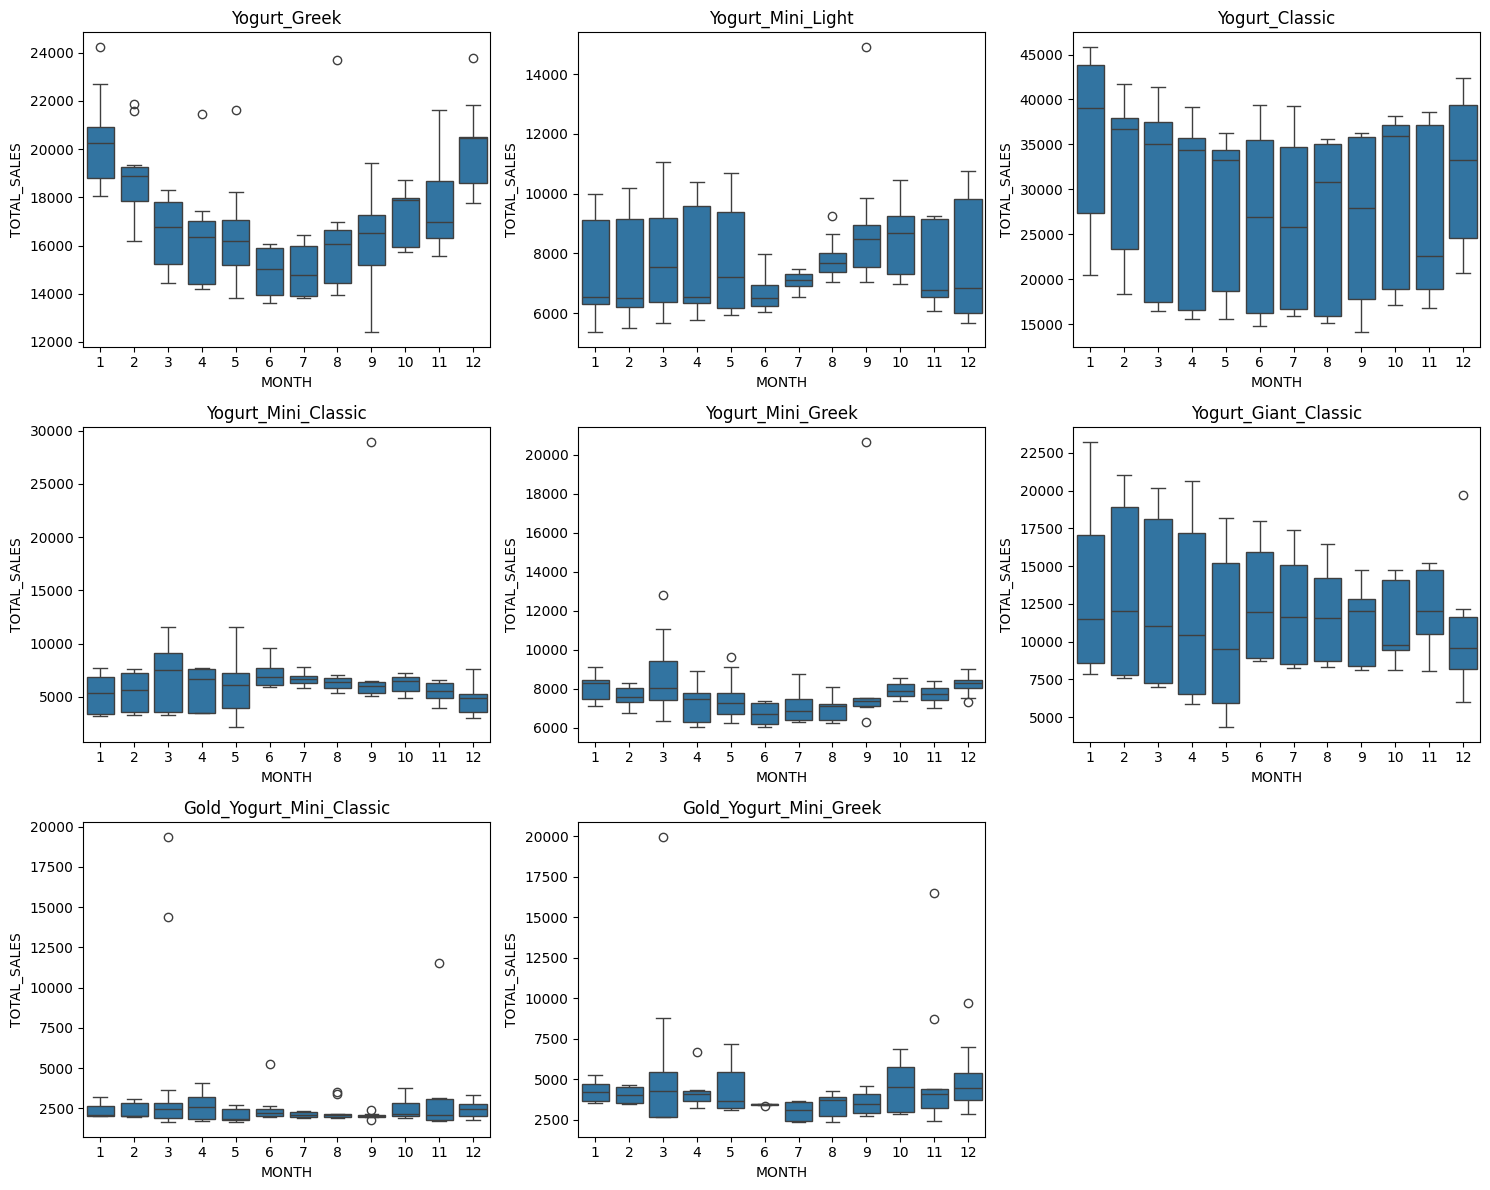

In [200]:
# boxplot of TOTAL_SALES by MONTH for each PRODUCT_DESC
products = df_train['PRODUCT_DESC'].unique()
n_products = len(products)

n_cols = 3
n_rows = math.ceil(n_products / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='MONTH',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('MONTH')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

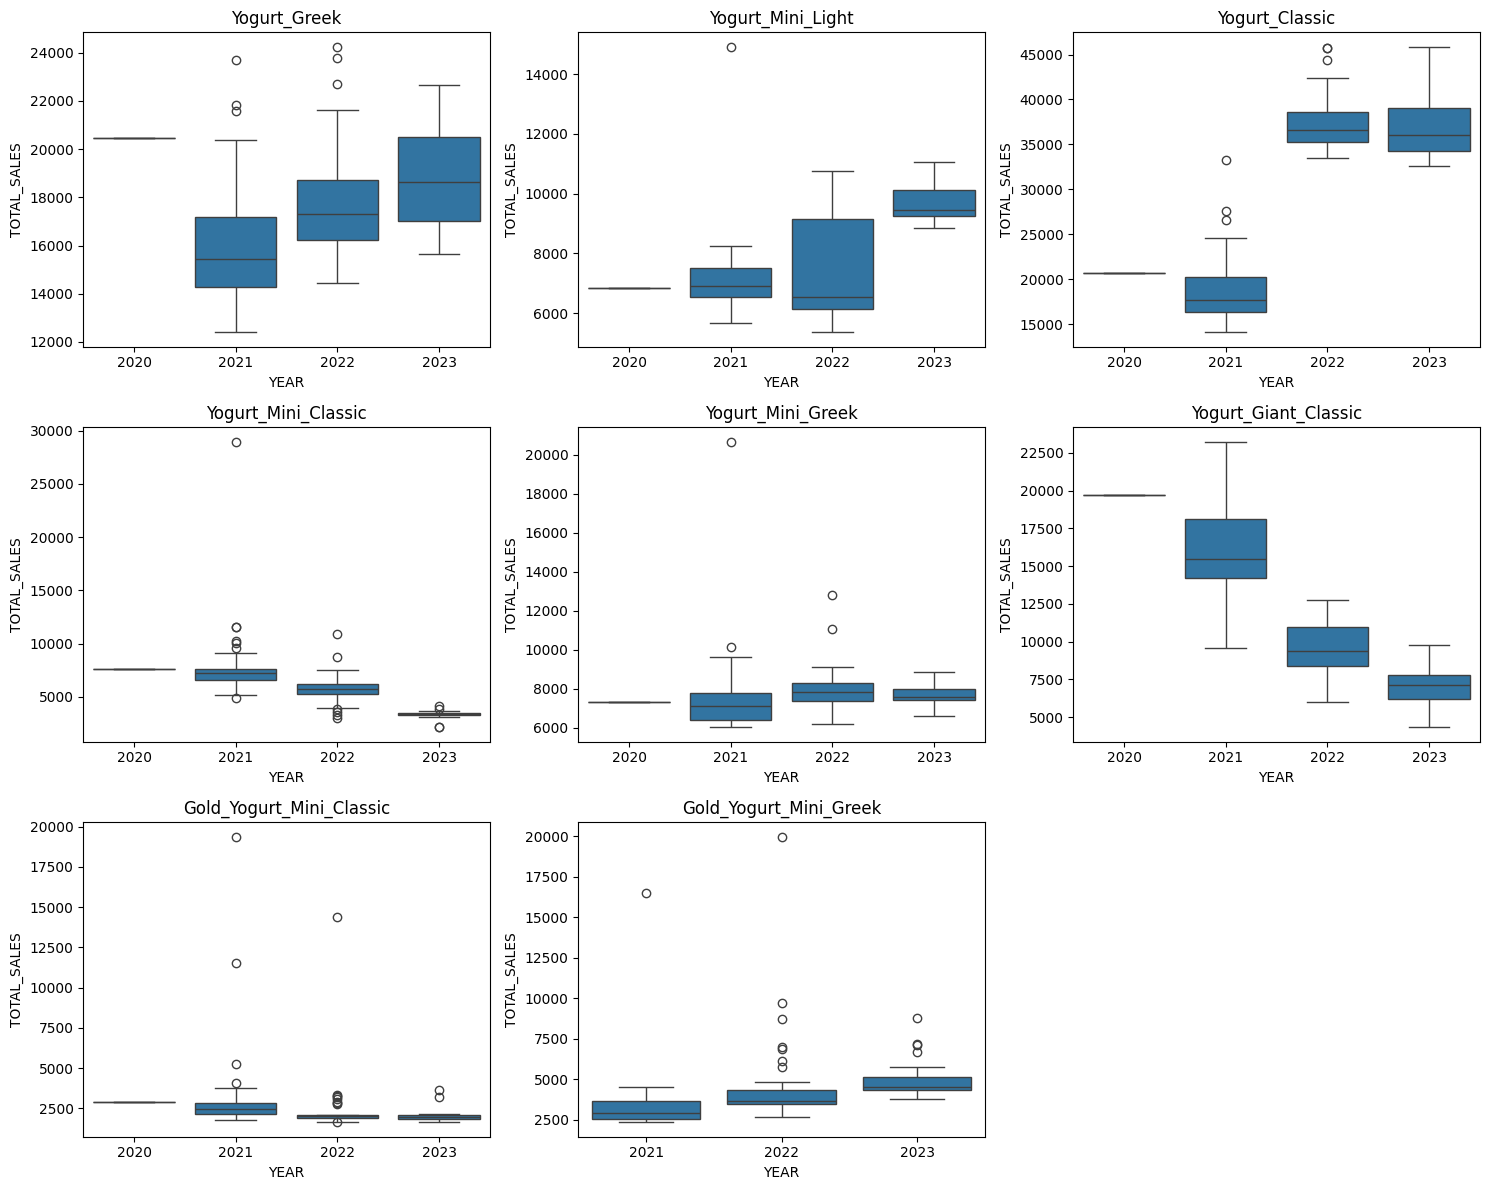

In [201]:
# boxplot of TOTAL_SALES by YEAR for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='YEAR',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(product)
    ax.set_xlabel('YEAR')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

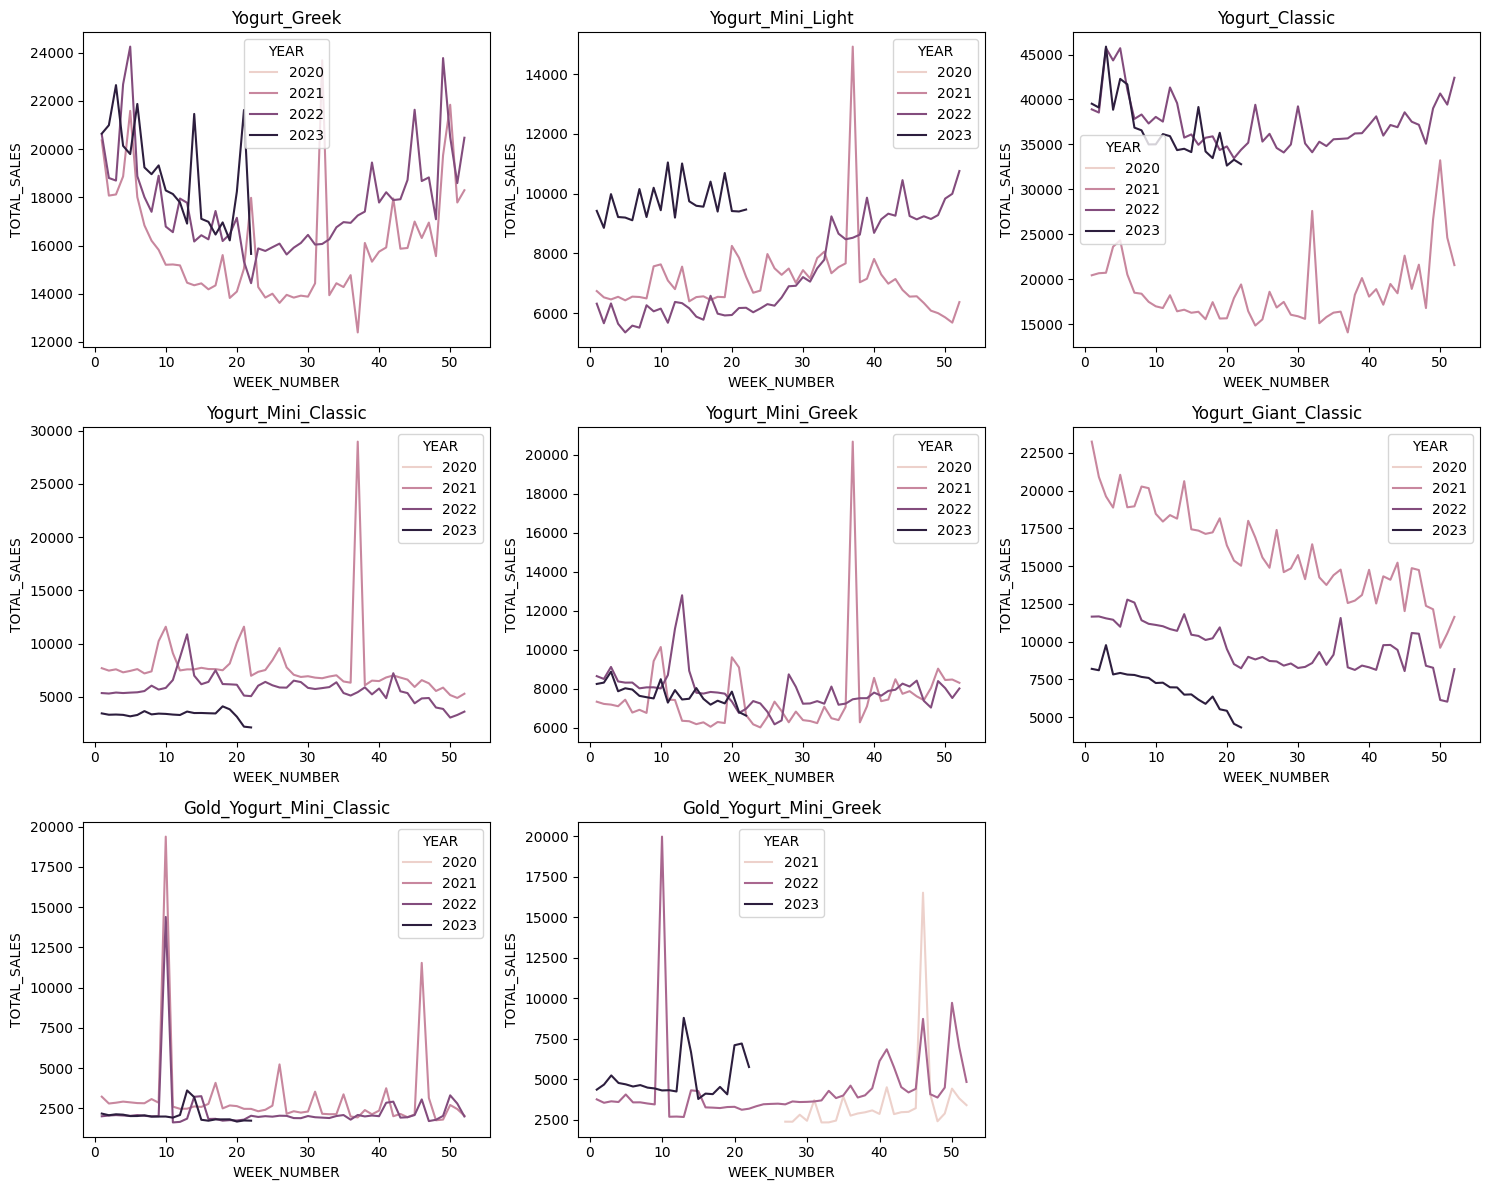

In [202]:
# lineplot of TOTAL_SALES over time for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.lineplot(
        x='WEEK_NUMBER',
        y='TOTAL_SALES',
         hue='YEAR',
         data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('WEEK_NUMBER')
    ax.set_ylabel('TOTAL_SALES')
    ax.legend(title='YEAR')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

After plotting, since we have the transformed version of WEEK_NUMBER, MONTH, and SEASON, they are redundant and we eliminate them.

In [203]:
df_train.drop(columns=['WEEK_NUMBER', 'MONTH', 'SEASON'], inplace=True)
df_test.drop(columns=['WEEK_NUMBER', 'MONTH', 'SEASON', 'TOTAL_SALES'], inplace=True)

In [204]:
df_train.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,Yogurt_Mini_Light,3450015116,6858.569570,4.997333,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,Yogurt_Classic,3450015119,20663.357359,4.804220,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,Yogurt_Mini_Classic,3450015129,7592.988504,5.000104,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,Yogurt_Mini_Greek,3450015179,7317.517962,5.714844,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
# dropping entries with missing values, which are generated by lag and rolling features
df_train.dropna(inplace=True)
df_train.shape

(573, 30)

## Preparing dataset for training
Splitting the dataset into training and test dataset. Standardizing numerical feature in order to enable better performances of our regression model.

In [206]:
X = df_train.drop(columns=['TOTAL_SALES', 'PRODUCT_DESC']) # dropping non-numeric and target columns
y = df_train['TOTAL_SALES']


# train-test split
# entries from 2021 and 2022 in train set, entries from 2023 in test set
X_train = X[X['YEAR'] < 2023]
y_train = y[X['YEAR'] < 2023]

X_val = X[X['YEAR'] == 2023]
y_val = y[X['YEAR'] == 2023]

In [207]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((397, 28), (176, 28), (397,), (176,))

In [208]:
X_train

,PRODUCT_ID,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
52,3450014449,5.668695,False,False,False,False,False,False,False,False,...,6.123234e-17,17785.476704,15559.351357,20461.337740,18733.604558,2687.636463,17636.338921,2142.860076,16066.859886,2423.677770
179,3450015116,4.988029,False,False,False,False,False,False,False,False,...,6.123234e-17,5683.267502,6083.144001,6858.569570,5906.494723,175.096863,6232.998671,385.556093,7118.075648,1251.436428
306,3450015119,4.803836,False,False,False,False,False,False,False,False,...,6.123234e-17,24620.017845,16790.015026,20663.357359,25319.043681,6771.284095,22858.436667,5324.685926,18690.257819,3624.493147
433,3450015129,4.997356,False,False,False,False,False,False,False,False,...,6.123234e-17,4893.926358,5546.527955,7592.988504,5366.810589,425.750695,5854.882556,627.251190,7791.873984,3275.225260
560,3450015179,5.730636,False,False,False,False,False,False,False,False,...,6.123234e-17,8473.952598,8038.844241,7317.517962,8498.458137,407.852897,8079.690014,536.908167,7503.730353,2111.390412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,3450015129,5.765199,False,False,False,False,False,False,False,False,...,6.123234e-17,3295.981606,3994.055928,5287.601086,3550.235084,451.172568,4209.539352,806.118750,5757.823716,1195.608120
612,3450015179,6.587025,False,False,False,False,False,False,False,False,...,6.123234e-17,7526.120852,7034.397183,8304.651521,7746.959491,593.679837,7895.189324,516.464986,7935.662059,1033.057712
739,3450015195,4.875907,False,False,False,False,False,False,False,False,...,6.123234e-17,6028.208133,8405.493089,11640.808041,7212.679104,1303.543499,8432.740782,1740.911699,9692.454698,1544.762783
866,767707002231,8.553143,False,False,False,False,False,False,False,False,...,6.123234e-17,2800.889664,1793.967141,2044.454625,2485.530422,698.286543,2343.913921,617.677422,2335.766707,1751.984291


In [209]:
# using these for negative MAPE calculation, which is the metric we are using for model evaluation and hyperparameter tuning
y_train = np.log1p(y_train) # applying log transformation to the target variable to reduce skewness
y_val = np.log1p(y_val) # applying log transformation to the target variable to reduce skewness

## Creating the Regression Model
We're gonna use XGBoost for this regression task.

In [210]:
# creating model
base_est = xgb.XGBRegressor(tree_method='hist', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}


gscv = GridSearchCV(estimator=base_est,
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_percentage_error', # using negative MAPE as scoring metric
                    cv=tscv,
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_params)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score:  0.013173828706733401


In [211]:
# assessing model performance on the validation set
y_pred = xbm.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE on validation set: {mape}")

MAPE on validation set: 0.009973995628525993


Now we can use this model to predict 'TOTAL_SALES' for the Test Set.

In [212]:
X_test = df_test.drop(columns=['PRODUCT_DESC']) # dropping non-numeric and target columns

preds_log = xbm.predict(X_test)
preds = np.expm1(preds_log) # applying inverse log transformation to get predictions in original scale

In [213]:
# adding predictions to the original test DataFrame for presentation purposes
df_test_original['TOTAL_SALES_PRED'] = preds
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,TOTAL_SALES_PRED
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False,17168.859375
1041,Yogurt_Mini_Light,3450015116,2023-06-05,5.748021,False,False,False,False,False,False,False,False,False,False,False,False,False,8984.820312
1093,Yogurt_Classic,3450015119,2023-06-05,5.230849,False,False,False,False,False,False,False,False,False,False,False,False,False,32902.042969
1145,Yogurt_Mini_Classic,3450015129,2023-06-05,5.748474,True,False,True,True,False,False,False,False,False,False,False,False,False,3900.429443
1197,Yogurt_Mini_Greek,3450015179,2023-06-05,6.570619,False,False,False,False,False,False,False,False,False,False,False,False,False,7158.148438


## Bonus Model: predicting baseline sales

In [214]:
mask_train = X_train['PROMO_LEVEL'].eq(0)
X_train = X_train.loc[mask_train]
y_train = y_train.loc[X_train.index]

mask_val = X_val['PROMO_LEVEL'].eq(0)
X_val = X_val.loc[mask_val]
y_val = y_val.loc[X_val.index]


In [215]:
# creating model
baseline_sales_est = xgb.XGBRegressor(tree_method='hist', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}



gscv = GridSearchCV(estimator=baseline_sales_est,
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_percentage_error', # using negative MAPE as scoring metric
                    cv=tscv,
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm_baseline, xbm_params_baseline = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_params_baseline)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
Best score:  0.009669378860722907


In [216]:
# assessing model performance on the validation set
y_pred = xbm_baseline.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE on validation set: {mape}")

MAPE on validation set: 0.012620714661475982


We also want to perform predictions for the baseline sales.

In [217]:
# Predicting baseline sales using the model trained only on non-promotional data
baseline_log_preds = xbm_baseline.predict(X_test)
baseline_preds = np.expm1(baseline_log_preds) # applying inverse log transformation to get predictions in original scale


In [218]:
# add baseline predictions to the test set
df_test_original['BASELINE_PRED'] = baseline_preds
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,TOTAL_SALES_PRED,BASELINE_PRED
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False,17168.859375,18035.052734
1041,Yogurt_Mini_Light,3450015116,2023-06-05,5.748021,False,False,False,False,False,False,False,False,False,False,False,False,False,8984.820312,8427.623047
1093,Yogurt_Classic,3450015119,2023-06-05,5.230849,False,False,False,False,False,False,False,False,False,False,False,False,False,32902.042969,29653.607422
1145,Yogurt_Mini_Classic,3450015129,2023-06-05,5.748474,True,False,True,True,False,False,False,False,False,False,False,False,False,3900.429443,4238.414551
1197,Yogurt_Mini_Greek,3450015179,2023-06-05,6.570619,False,False,False,False,False,False,False,False,False,False,False,False,False,7158.148438,7100.213867


In [219]:
# save predictions to CSV
output_path = os.path.join(parent_dir, 'data', 'processed', 'test_predictions.csv')
df_test_original.to_csv(output_path, index=False)   

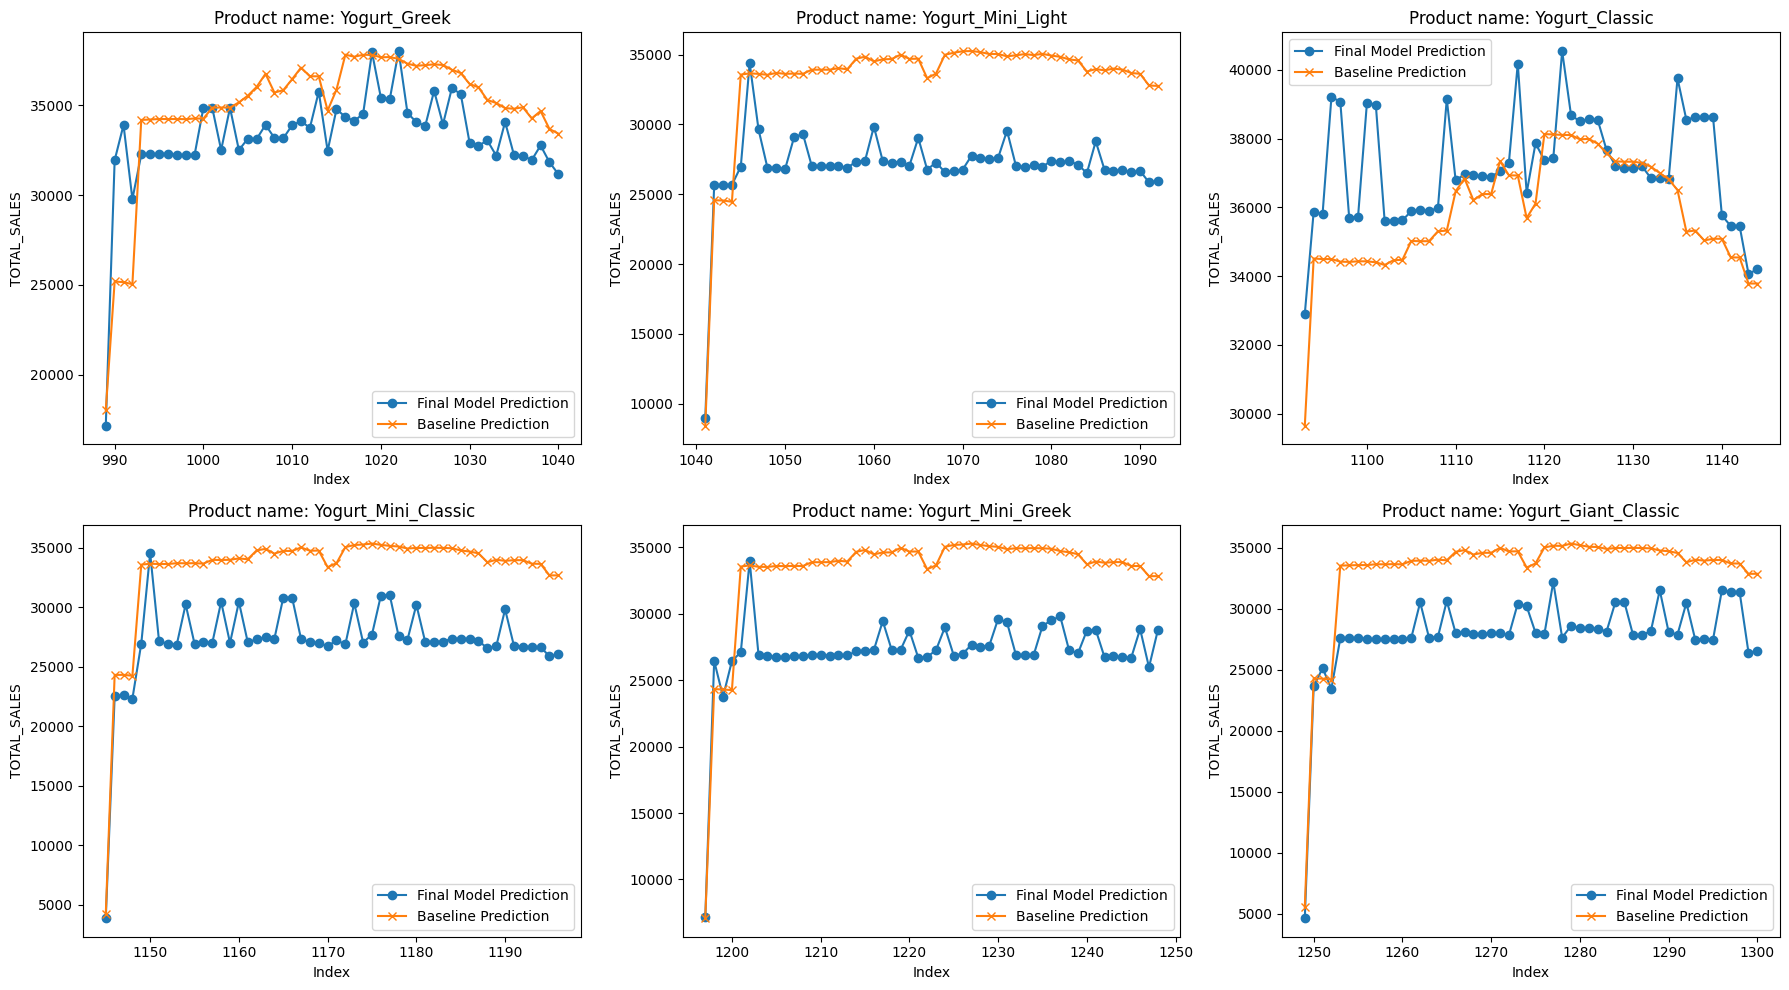

In [220]:
# creating a plot comparing actual sales, baseline predictions and final model predictions for a sample of products
sample_products = df_test_original['PRODUCT_DESC'].unique()[:6] # taking a sample of 6 products for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for ax, product in zip(axes, sample_products):
    product_data = df_test_original[df_test_original['PRODUCT_DESC'] == product]
    ax.plot(product_data.index, product_data['TOTAL_SALES_PRED'], label='Final Model Prediction', marker='o')
    ax.plot(product_data.index, product_data['BASELINE_PRED'], label='Baseline Prediction', marker='x')
    ax.set_title(f'Product name: {product}')
    ax.set_xlabel('Index')
    ax.set_ylabel('TOTAL_SALES')
    ax.legend()
plt.tight_layout()
plt.show()